In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from collections import Counter
import time
from copy import deepcopy

import sys, os

sys.path.append(os.path.abspath("../../src"))
from SegmentationAndLabeling import SegmentationAndLabeling
from SegLabel import SegLabel
from docplex.mp.model import Model
from read_model import read_model

from dwave_utils import (
    plot_qpu_pegasus_embedding,
    plot_qubo_matrix,
    get_embedding_with_short_chain,
)

import minorminer
import dimod
from dimod import BinaryQuadraticModel
from dwave.system import (
    DWaveSampler,
    EmbeddingComposite,
    FixedEmbeddingComposite,
    LazyFixedEmbeddingComposite,
)
from neal import SimulatedAnnealingSampler
from tabu import TabuSampler

%load_ext lab_black

## Model

In [2]:
from SegmentationAndLabeling_NEW_VERSION import SegmentationAndLabeling

# read the data
with open("018340451_hipster_SegLabelData.pickle", "rb") as f:
    segLabel = pickle.load(f)

# beta_dc_d'c'u
B = segLabel.betas.copy()
B = np.nan_to_num(B, nan=0.0)
B_max = np.max(B)

print("B:")
print("  shape: ", np.shape(B))
print("  min/max: ", np.min(B), B_max)

# alpha_dc
A = segLabel.alphas.copy()
A = np.nan_to_num(A, nan=0.0)
A_max = B_max
A[A > A_max] = A_max  # truncate too high values

print("A:")
print("  shape: ", np.shape(A))
print("  min/max: ", np.min(A), np.max(A))
print("")

max_num_segments = segLabel.max_num_persons
suppress = False

model = SegmentationAndLabeling(
    A=A,
    B=B,
    max_num_segments=max_num_segments,
    suppress=suppress,
    class_reindex={v: k for k, v in segLabel.map_DNNclass_reindex.items()},
)

B:
  shape:  (4, 4, 2, 2)
  min/max:  -2.0 26.0
A:
  shape:  (4, 2)
  min/max:  -6.0 26.0

Segmentation and Labeling Problem initialization:
  Number of nodes:  4
  Number of labels:  2
  Maximum number of segments:  2


## CPLEX

In [3]:
C = B_max

mdl = model.build_model(C=C)
mdl.solve()
mdl.print_information()
mdl.print_solution()

Model: Segmentation and Labeling
 - number of variables: 16
   - binary=16, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP
objective: -15.000
status: OPTIMAL_SOLUTION(2)
  x_0_0_0=1
  x_1_0_1=1
  x_2_1_0=1
  x_3_1_1=1


Objective:  -15.0


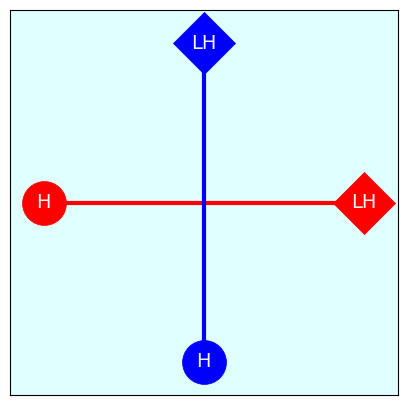

In [4]:
x = np.zeros(mdl.number_of_binary_variables)
for v in mdl.iter_binary_vars():
    x[v.index] = v.solution_value

fig = plt.figure(figsize=(5, 5), frameon=False)
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index
ax.set_facecolor("lightcyan")

model.draw_solution(
    ax,
    x,
    node_size=1000,
    width=3,
    alpha=1.0,
)

print("Objective: ", mdl.objective_value)
plt.show()

## BQM setup

In [5]:
tic = time.perf_counter()
Q, offset = model.build_qubo(C=C, norm=False)
toc = time.perf_counter()
print(f"\n>>>> QUBO setup: {toc - tic:0.4f} seconds")

tic = time.perf_counter()
bqm = BinaryQuadraticModel.from_qubo(Q, offset=offset)
toc = time.perf_counter()
print(f">>>> BQM setup: {toc - tic:0.4f} seconds")


>>>> QUBO setup: 0.0014 seconds
>>>> BQM setup: 0.0043 seconds


In [6]:
print("Number of QUBO variables: ", bqm.num_variables)
print("Number of QUBO interactions: ", bqm.num_interactions)
print(
    "Matrix sparsity: ",
    bqm.num_interactions / (0.5 * bqm.num_variables * (bqm.num_variables - 1)),
)
print("Energy offset:", bqm.offset)

Number of QUBO variables:  16
Number of QUBO interactions:  70
Matrix sparsity:  0.5833333333333334
Energy offset: 104.0


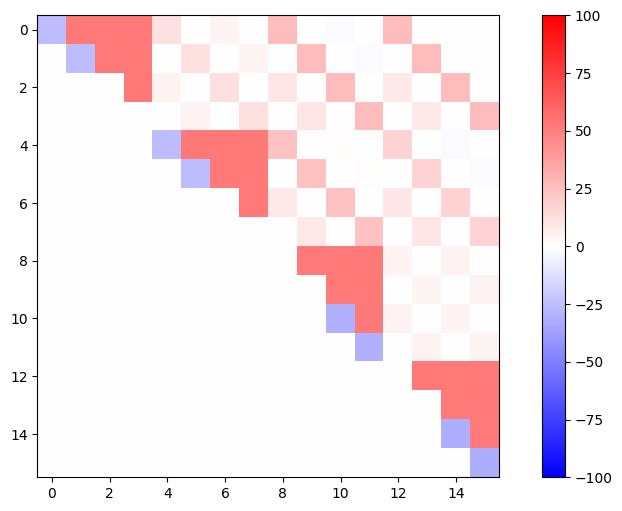

In [7]:
plot_qubo_matrix(Q, vmin=-100, vmax=100)

## Simulated Annealing

In [8]:
%%time

sampler = SimulatedAnnealingSampler()

n_runs = 1
num_reads = 10_000

np.random.seed(1234)
seeds = np.random.randint(2**16 - 1, size=n_runs)

sols = Counter(dict())
for _seed in seeds:
    sampleset = sampler.sample(bqm, num_reads=num_reads, seed=_seed)
    for data in sampleset.aggregate().data():
        x = list(data.sample.values())
        x_str = "".join([str(int(i)) for i in x])
        sols += Counter({x_str: data.num_occurrences})

sols = dict(sols)

CPU times: user 1.96 s, sys: 7.07 ms, total: 1.97 s
Wall time: 1.98 s


In [9]:
print("Total number of solutions: ", len(sols))

# extract solution info into dictionary
results = []

for s, p in sols.items():
    x = [int(i) for i in s]
    obj = bqm.energy(x)
    results.append(
        {
            "x": x,
            "obj": obj,
            "prob": p / (num_reads * n_runs),
            "feas": model.is_valid(x),
        }
    )

results = sorted(results, key=lambda k: k["obj"])

Total number of solutions:  16


In [10]:
print("Objective: ", results[0]["obj"])

x = results[0]["x"]

n_bad = 0

n = model.num_labels * model.num_segments
for i in range(model.num_nodes):
    _x = x[i * n : (i + 1) * n]
    if sum(_x) != 1:
        n_bad += 1

print("Number of the undefined detections: ", n_bad)

Objective:  -15.0
Number of the undefined detections:  0


In [12]:
# compute success probability
sprob = np.sum(
    [item["prob"] for item in results if np.isclose(item["obj"], mdl.objective_value)]
)
print("Success probability: ", sprob)

Success probability:  0.5184


Objective:  -15.0


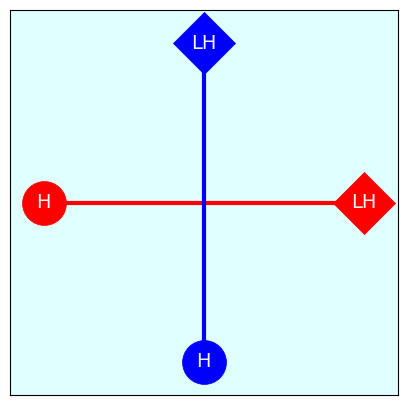

In [13]:
# draw the lowest energy solution
fig = plt.figure(figsize=(5, 5), frameon=False)
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index

i = 0

print("Objective: ", results[i]["obj"])
model.draw_solution(
    ax,
    results[i]["x"],
    node_size=1000,
    width=3,
    alpha=1.0,
)
ax.set_facecolor("lightcyan")
plt.show()

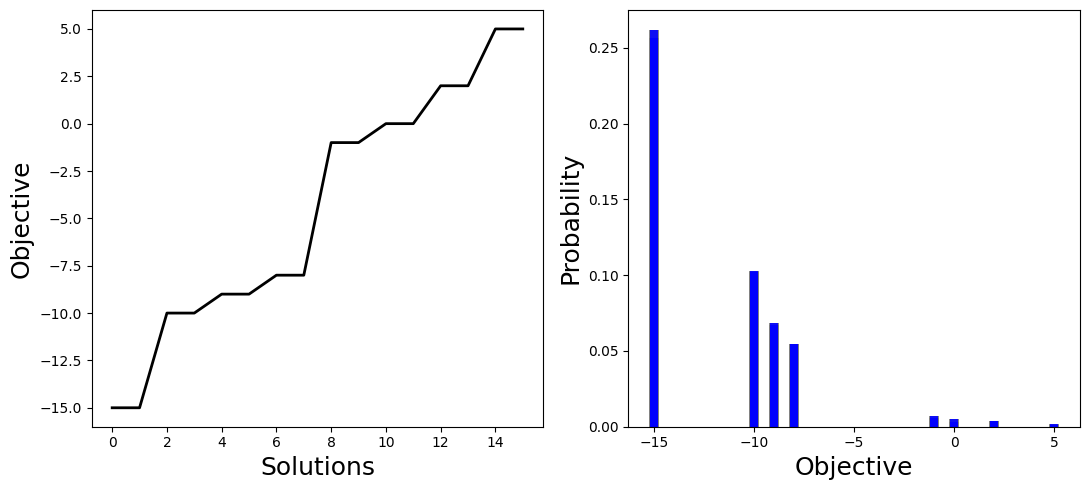

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

objs = [v["obj"] for v in results]
probs = [v["prob"] for v in results]

objs_feas = [v["obj"] for v in results if v["feas"]]
probs_feas = [v["prob"] for v in results if v["feas"]]

ax[0].plot(objs, c="k", lw=2, label="neal")
ax[0].set_xlabel("Solutions", fontsize=18)
ax[0].set_ylabel("Objective", fontsize=18)

ax[1].bar(objs, probs, width=0.5, color="grey", alpha=0.9)
ax[1].bar(objs_feas, probs_feas, width=0.4, color="b", alpha=0.9)
ax[1].set_xlabel("Objective", fontsize=18)
ax[1].set_ylabel("Probability", fontsize=18)

plt.tight_layout()
plt.show()

In [15]:
res_sa = deepcopy(results)

## QPU

In [16]:
# get QPU sampler
sampler = DWaveSampler(region="eu-central-1", solver=dict(qpu=True))

In [17]:
if False:
    with open("minorminer_embedding.pkl", "rb") as f:
        embedding = pickle.load(f)
else:
    embedding = get_embedding_with_short_chain(bqm, sampler, num_tries=4, verbose=True)

0 max_chain_length: 3
1 max_chain_length: 3
2 max_chain_length: 2
3 max_chain_length: 3

INFO:
	Max chain length in best embedding: 2
	Number of physical qubits in best embedding: 30


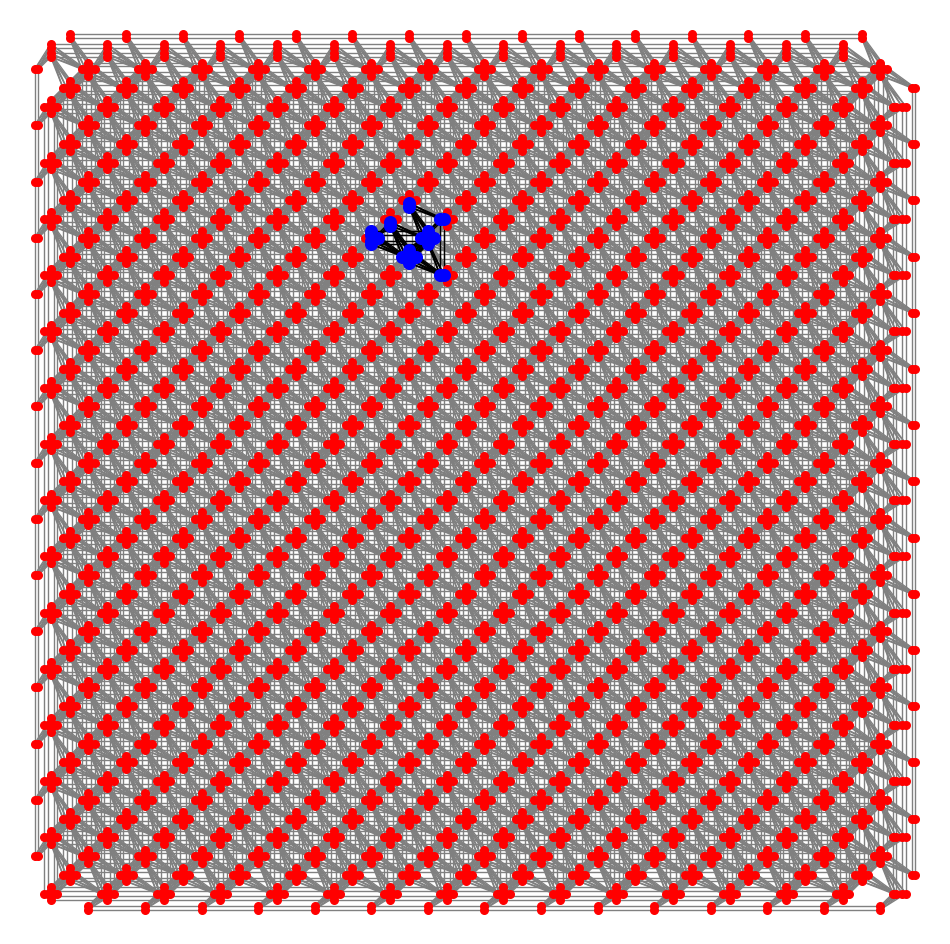

In [18]:
plot_qpu_pegasus_embedding(embedding)

In [19]:
n_runs = 1
num_reads = 1_024

annealing_time = 20
chain_strength = 0.8 * B_max

solver = FixedEmbeddingComposite(
    sampler,
    embedding=embedding,
)

sols = Counter(dict())
for _ in range(n_runs):
    response = solver.sample(
        bqm,
        num_reads=num_reads,
        chain_strength=chain_strength,
        annealing_time=annealing_time,
        label="SLP",
        return_embedding=False,
    )

    for data in response.aggregate().data():
        x = list(data.sample.values())
        x_str = "".join([str(int(i)) for i in x])
        sols += Counter({x_str: data.num_occurrences})

sols = dict(sols)

In [20]:
print("Total number of solutions: ", len(sols))

# extract solution info into dictionary
results = []

for s, p in sols.items():
    x = [int(i) for i in s]
    obj = bqm.energy(x)
    results.append(
        {
            "x": x,
            "obj": obj,
            "prob": p / (num_reads * n_runs),
            "feas": model.is_valid(x),
        }
    )

results = sorted(results, key=lambda k: k["obj"])

Total number of solutions:  39


In [21]:
print("Objective: ", results[0]["obj"])

x = results[0]["x"]

n_bad = 0

n = model.num_labels * model.num_segments
for i in range(model.num_nodes):
    _x = x[i * n : (i + 1) * n]
    if sum(_x) != 1:
        n_bad += 1

print("Number of the undefined detections: ", n_bad)

Objective:  -15.0
Number of the undefined detections:  0


In [22]:
# compute success probability
sprob = np.sum(
    [item["prob"] for item in results if np.isclose(item["obj"], mdl.objective_value)]
)
print("Success probability: ", sprob)

if suppress:
    N = model.num_labels * model.num_segments + 1
else:
    N = model.num_labels * model.num_segments

print(
    "Coefficient of performance (wrt. feasible subspace): ",
    sprob * N**model.num_nodes,
)
print(
    "Coefficient of performance (wrt. entire space ): ",
    sprob * 2 ** (model.num_nodes * N),
)

Success probability:  0.384765625
Coefficient of performance (wrt. feasible subspace):  98.5
Coefficient of performance (wrt. entire space ):  25216.0


Objective:  -15.0


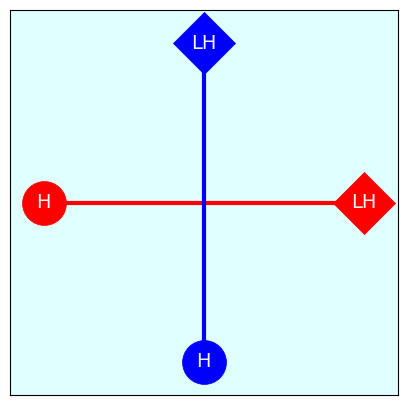

In [23]:
# draw the lowest energy solution
fig = plt.figure(figsize=(5, 5), frameon=False)
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index
ax.set_facecolor("lightcyan")

i = 0

print("Objective: ", results[i]["obj"])
model.draw_solution(
    ax,
    results[i]["x"],
    node_size=1000,
    width=3,
    alpha=1.0,
)

plt.show()

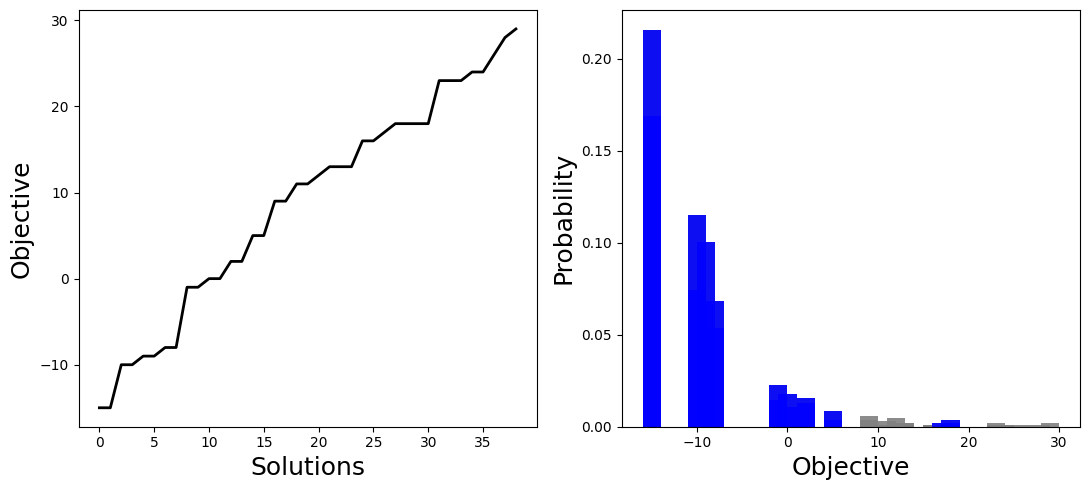

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

objs = [v["obj"] for v in results]
probs = [v["prob"] for v in results]

objs_feas = [v["obj"] for v in results if v["feas"]]
probs_feas = [v["prob"] for v in results if v["feas"]]

ax[0].plot(objs, c="k", lw=2, label="neal")
ax[0].set_xlabel("Solutions", fontsize=18)
ax[0].set_ylabel("Objective", fontsize=18)

ax[1].bar(objs, probs, width=2, color="grey", alpha=0.9)
ax[1].bar(objs_feas, probs_feas, width=2, color="b", alpha=0.9)
ax[1].set_xlabel("Objective", fontsize=18)
ax[1].set_ylabel("Probability", fontsize=18)

plt.tight_layout()
plt.show()

In [25]:
res_qpu = deepcopy(results)

## Comparison

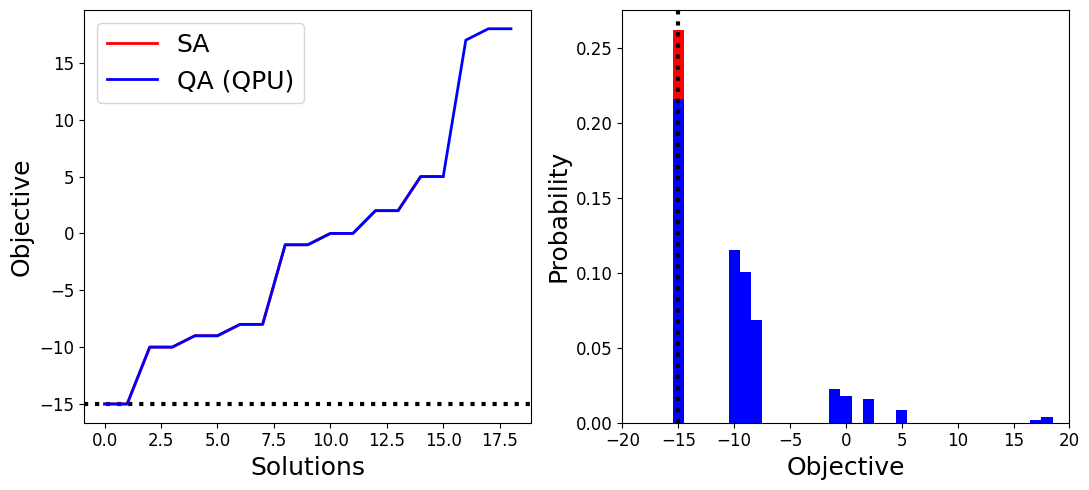

In [26]:
import matplotlib as mpl

label_size = 12
mpl.rcParams["xtick.labelsize"] = label_size
mpl.rcParams["ytick.labelsize"] = label_size

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

objs_sa = [v["obj"] for v in res_sa if v["feas"]]
probs_sa = [v["prob"] for v in res_sa if v["feas"]]

objs_qpu = [v["obj"] for v in res_qpu if v["feas"]]
probs_qpu = [v["prob"] for v in res_qpu if v["feas"]]


# *********************************
ax[0].axhline(y=mdl.objective_value, c="k", ls=":", lw=3)
ax[0].plot(objs_sa, c="red", lw=2, label="SA")
ax[0].plot(objs_qpu, c="blue", lw=2, label="QA (QPU)")
ax[0].legend(fontsize=18)

# ax[0].set_xlim(-100, 1000)
# ax[0].set_ylim(-100, 10000)

ax[0].set_xlabel("Solutions", fontsize=18)
ax[0].set_ylabel("Objective", fontsize=18)

# *********************************
ax[1].bar(objs_sa, probs_sa, width=1, color="red", alpha=1.0)
ax[1].bar(objs_qpu, probs_qpu, width=1, color="blue", alpha=1.0)

ax[1].axvline(x=mdl.objective_value, c="k", ls=":", lw=3)
# ax[1].axhline(y=1 / n_feas, c="b", ls=":", lw=2)

ax[1].set_xlim(mdl.objective_value - 5, 20)
ax[1].set_xlabel("Objective", fontsize=18)
ax[1].set_ylabel("Probability", fontsize=18)

plt.tight_layout()
plt.show()